In [1]:
from gensim.models import Word2Vec
import responsibly
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from IPython.display import display
from itertools import combinations, product
import random

In [2]:
plt.rcParams["figure.figsize"] = (12,4)


red_patch = mpatches.Patch(color='red', label='Aggregated')
blue_patch = mpatches.Patch(color='blue', label='Single')

In [3]:
# Load the gensim model
model = Word2Vec.load("word2vec.gnsm")

# Utils

In [4]:
def make_experiment(attribute_male, attribute_female, target_1, target_2, plot_name=None):
    try:
        res = responsibly.we.weat.calc_single_weat(model.wv, target_1, target_2, attribute_male, attribute_female,
                                         with_pvalue=True)
        return pd.DataFrame([res])
    except AssertionError:
        difference = abs(len(target_1['words']) - len(target_2['words']))

        class_name = target_1['name']   
        bigger_target = target_1['words']
        is_target1_bigger = True
        
        if len(target_1['words']) < len(target_2['words']):
            bigger_target = target_2['words']
            is_target1_bigger = False
            class_name = target_2['name']   
            
        results = []
        
        for words in combinations(bigger_target, difference):
            reduced_bigger = [w for w in bigger_target if w not in words]
            
            if is_target1_bigger:
                results.append(make_experiment(attribute_male, attribute_female, {'name': target_1['name'], 'words': reduced_bigger}, target_2))
            else:
                results.append(make_experiment(attribute_male, attribute_female, target_1, {'name': target_2['name'], 'words': reduced_bigger}))                
        
        results = pd.concat(results)
        
        results.plot(kind='scatter', x='p', y='d')
        plt.title(f'Removing all combinations of size {difference} words from {class_name}')
        
        if plot_name:
            plt.savefig(plot_name, format='eps')
        
        plt.show()
        
        return pd.concat([pd.DataFrame(results['d'].describe()).T, pd.DataFrame(results['p'].describe()).T]).T

In [5]:
def evaluate_experiment(results: pd.DataFrame, attribute_male, attribute_female, target_1, target_2):
    try:
        r = results.loc['mean']
    except KeyError:
        r = results.iloc[0, :]
        
    output = 'The result is significant. '
    if r['p'] > 0.05:
        output = 'The result is NOT significant. '
        
    output += f'alpha=0.05 ({r["p"]:.3f})\n'
        
    output += 'The suggested association is: '
    if r['d'] > 0:
        output += f'{target_1["name"]}-{attribute_male["name"]} and {target_2["name"]}-{attribute_female["name"]}'
    else:
        output += f'{target_2["name"]}-{attribute_male["name"]} and {target_1["name"]}-{attribute_female["name"]}'
        
    output += f'({r["d"]:.3f})\n'
    print(output)

In [6]:
def experiment_word_frequency(*classes):
    results = []
    total_occ = sum([model.wv.vocab[word].count for word in model.wv.vocab])
    
    for c in classes:
        count = sum([model.wv.vocab[word].count for word in c['words']])
        c['count'] = count
        results.append({
            'class': c['name'],
            'count': count
        })
        
    target_classes = [c for c in classes if c['name'] not in ['male', 'female']]
    
    bigger_c = target_classes[0] if target_classes[0]['count'] > target_classes[1]['count'] else target_classes[1]
    smaller_c = target_classes[0] if target_classes[0]['count'] < target_classes[1]['count'] else target_classes[1]
        
    percentage_increase = bigger_c['count'] / smaller_c['count'] - 1
    
    print(f"{bigger_c['name']} words are {percentage_increase*100:.3f}% more frequent than {smaller_c['name']} words")

    target_classes = [c for c in classes if c['name'] in ['male', 'female']]
    
    bigger_c = target_classes[0] if target_classes[0]['count'] > target_classes[1]['count'] else target_classes[1]
    smaller_c = target_classes[0] if target_classes[0]['count'] < target_classes[1]['count'] else target_classes[1]
        
    percentage_increase = bigger_c['count'] / smaller_c['count'] - 1
    
    print(f"{bigger_c['name']} words are {percentage_increase*100:.3f}% more frequent than {smaller_c['name']} words")
     
    return pd.DataFrame(results)

In [7]:
def male_term_percentage(experiment):
    target_classes = [k.split('_')[0] for k in experiment.keys() if 'no_male' in k]
    
    return pd.DataFrame([
        {
            'class': experiment[k]['name'],
            'male terms': f"{1 - len(experiment[f'{k}_no_male']['words'])/len(experiment[k]['words']):.3f}%"
        }
        for k in target_classes
    ])

# Classes

In [8]:
weat7 = {
    'male': {
        'name': 'male',
        'words':["maschio", "uomo", "ragazzo", "fratello", "lui", "suo", "lo", "figlio"]
    },
    'female': {
        'name': 'female',
        'words': ["femmina", "donna", "ragazza", "sorella", "lei", "sua", "la", "figlia"]
    },
    'math': {
        'name': 'math',
        'words': ["matematica", "algebra", "geometria", "calcolo", "equazioni", "computazione", "numeri", "addizione"]  
    },
    'art': {
        'name': 'art',
        'words': ["poesia", "arte", "danza", "letteratura", "romanzo", "sinfonia", "dramma", "scultura"]
    },
    'math_no_male': {
        'name': 'math_no_male',
        'words': ["matematica", "algebra", "geometria", "equazioni", "computazione", "addizione"]
    },
    'art_no_male': {
        'name': 'art_no_male',
        'words': ["poesia", "arte", "danza", "letteratura", "sinfonia", "dramma", "scultura"]
    }
}

weat8 = {
    'male': {
        'name': 'male',
        'words': ["fratello", "padre", "zio", "nonno", "figlio", "lui", "suo", "lo"]
    },
    'female': {
        'name': 'female',
        'words': ["sorella", "madre", "zia", "nonna", "figlia", "lei", "sua", "la"]
    },
    'science': {
        'name': 'science',
        # removed nasa because not in vocabulary
        'words': ["scienza", "tecnologia", "fisica", "chimica", "einstein", "esperimento", "astronomia"]
    },
    'art': {
        'name': 'art',
        'words': ["poesia", "arte", "shakespeare", "danza", "letteratura", "romanzo", "sinfonia", "dramma"]
    },
    'science_no_male': {
        'name': 'science_no_male',
        'words': ["scienza", "tecnologia", "fisica", "chimica", "astronomia"]
    },
    'art_no_male': {
        'name': 'art_no_male',
        'words': ["poesia", "arte", "danza", "letteratura", "sinfonia", "dramma"]
    }
}

weat8_implicit = {
    'male': {
        'name': 'male',
        'words': ["uomo", "padre", "maschio", "nonno", "marito", "zio"]
    },
    'female': {
        'name': 'female',
        'words': ["donna", "madre", "femmina", "nonna", "moglie", "zia"]
    },
    'science': {
        'name': 'science',
        'words': ["biologia", "fisica", "chimica", "matematica", "geologia", "astronomia", "ingegneria"]
    },
    'art': {
        'name': 'art',
        'words': ["filosofia", "umanesimo", "arte", "letteratura", "italiano", "musica", "storia"]
    },
    'science_no_male': {
        'name': 'science_no_male',
        'words': ["biologia", "fisica", "chimica", "matematica", "geologia", "astronomia", "ingegneria"]
    },
    'art_no_male': {
        'name': 'art_no_male',
        'words': ["filosofia", "arte", "letteratura", "italiano", "musica", "storia"]
    }
}

# WEAT 7

,Target words,Attrib. words,s,d,p,Nt,Na
0,math vs. art,male vs. female,0.203558,0.335644,0.264724,8x2,8x2


The result is NOT significant. alpha=0.05 (0.265)
The suggested association is: math-male and art-female(0.336)

art words are 4.826% more frequent than math words
female words are 404.502% more frequent than male words


,class,count
0,male,585374
1,female,2953226
2,math,11209
3,art,11750


,class,male terms
0,math,0.250%
1,art,0.125%


What happens if we run the same test without male terms in the target classes?


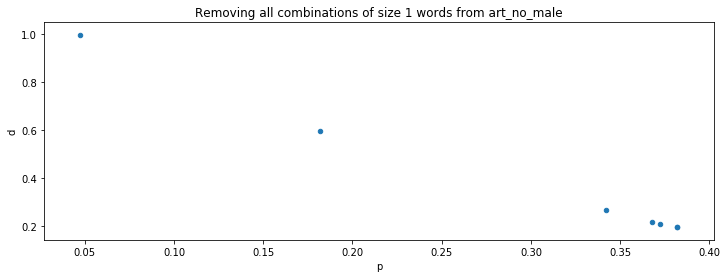

,d,p
count,7.000000,7.000000
mean,0.382557,0.296537
std,0.307154,0.130797
min,0.194130,0.047619
25%,0.201769,0.261905
50%,0.217322,0.367965
75%,0.432715,0.377165
max,0.997478,0.382035


The result is NOT significant. alpha=0.05 (0.297)
The suggested association is: math_no_male-male and art_no_male-female(0.383)

art_no_male words are 860.168% more frequent than math_no_male words
female words are 404.502% more frequent than male words


,class,count
0,male,585374
1,female,2953226
2,math_no_male,1190
3,art_no_male,11426


In [9]:
# esperimento standard
weat7_result = make_experiment(weat7['male'], weat7['female'], weat7['math'], weat7['art'])
display(weat7_result)

evaluate_experiment(weat7_result, weat7['male'], weat7['female'], weat7['math'], weat7['art'])

display(experiment_word_frequency(weat7['male'], weat7['female'], weat7['math'], weat7['art']))

display(male_term_percentage(weat7))

print("What happens if we run the same test without male terms in the target classes?")

# esperimento no male
weat7_result_no_male = make_experiment(weat7['male'], weat7['female'], weat7['math_no_male'], weat7['art_no_male'])
display(weat7_result_no_male)

evaluate_experiment(weat7_result_no_male, weat7['male'], weat7['female'], weat7['math_no_male'], weat7['art_no_male'])

display(experiment_word_frequency(weat7['male'], weat7['female'], weat7['math_no_male'], weat7['art_no_male']))

# WEAT 8

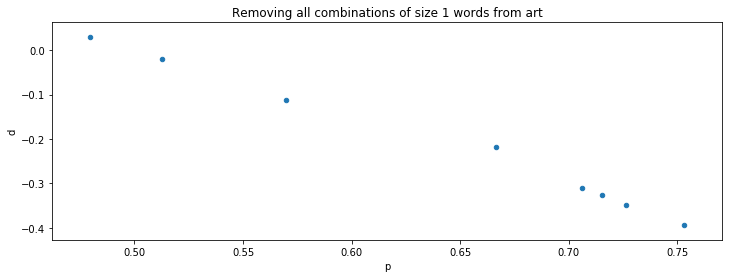

,d,p
count,8.000000,8.000000
mean,-0.212491,0.641171
std,0.160482,0.105455
min,-0.394527,0.479604
25%,-0.331763,0.555580
50%,-0.264569,0.686334
75%,-0.089162,0.718022
max,0.029958,0.753205


The result is NOT significant. alpha=0.05 (0.641)
The suggested association is: art-male and science-female(-0.212)

science words are 31.658% more frequent than art words
female words are 420.453% more frequent than male words


,class,count
0,male,566687
1,female,2949340
2,science,15454
3,art,11738


,class,male terms
0,science,0.286%
1,art,0.250%


What happens if we run the same test without male terms in the target classes?


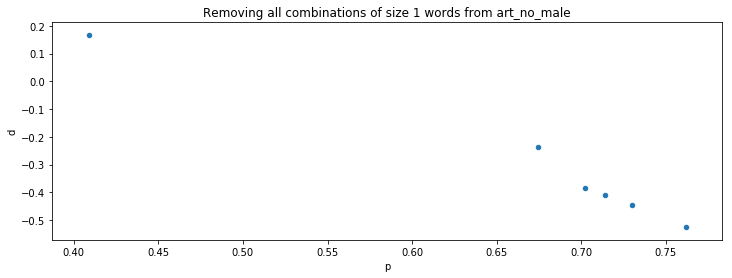

,d,p
count,6.000000,6.000000
mean,-0.306969,0.665344
std,0.250634,0.129018
min,-0.525680,0.408730
25%,-0.438624,0.681548
50%,-0.398824,0.708333
75%,-0.274759,0.726190
max,0.166807,0.761905


The result is NOT significant. alpha=0.05 (0.665)
The suggested association is: art_no_male-male and science_no_male-female(-0.307)

science_no_male words are 17.644% more frequent than art_no_male words
female words are 420.453% more frequent than male words


,class,count
0,male,566687
1,female,2949340
2,science_no_male,13362
3,art_no_male,11358


In [10]:
# esperimento standard
weat8_result = make_experiment(weat8['male'], weat8['female'], weat8['science'], weat8['art'], plot_name='weat8.ecs')
display(weat8_result)

evaluate_experiment(weat8_result, weat8['male'], weat8['female'], weat8['science'], weat8['art'])

display(experiment_word_frequency(weat8['male'], weat8['female'], weat8['science'], weat8['art']))

display(male_term_percentage(weat8))

print("What happens if we run the same test without male terms in the target classes?")

# esperimento no male
weat8_result_no_male = make_experiment(weat8['male'], weat8['female'], weat8['science_no_male'], weat8['art_no_male'])
display(weat8_result_no_male)

evaluate_experiment(weat8_result_no_male, weat8['male'], weat8['female'], weat8['science_no_male'], weat8['art_no_male'])

display(experiment_word_frequency(weat8['male'], weat8['female'], weat8['science_no_male'], weat8['art_no_male']))

# WEAT 8 Implicit

,Target words,Attrib. words,s,d,p,Nt,Na
0,science vs. art,male vs. female,-0.00769,-0.011787,0.507867,7x2,6x2


The result is NOT significant. alpha=0.05 (0.508)
The suggested association is: art-male and science-female(-0.012)

art words are 1100.087% more frequent than science words
male words are 72.139% more frequent than female words


,class,count
0,male,30040
1,female,17451
2,science,9217
3,art,110612


,class,male terms
0,science,0.000%
1,art,0.143%


What happens if we run the same test without male terms in the target classes?


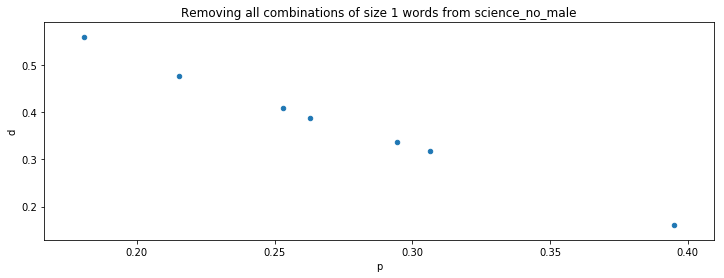

,d,p
count,7.000000,7.000000
mean,0.378670,0.272573
std,0.126526,0.069254
min,0.160983,0.180736
25%,0.327812,0.234307
50%,0.388700,0.262987
75%,0.443138,0.300325
max,0.559106,0.395022


The result is NOT significant. alpha=0.05 (0.273)
The suggested association is: science_no_male-male and art_no_male-female(0.379)

art_no_male words are 1096.441% more frequent than science_no_male words
male words are 72.139% more frequent than female words


,class,count
0,male,30040
1,female,17451
2,science_no_male,9217
3,art_no_male,110276


In [11]:
# esperimento standard
weat8_implicit_result = make_experiment(weat8_implicit['male'], weat8_implicit['female'], weat8_implicit['science'], weat8_implicit['art'])
display(weat8_implicit_result)

evaluate_experiment(weat8_implicit_result, weat8_implicit['male'], weat8_implicit['female'], weat8_implicit['science'], weat8_implicit['art'])

display(experiment_word_frequency(weat8_implicit['male'], weat8_implicit['female'], weat8_implicit['science'], weat8_implicit['art']))

display(male_term_percentage(weat8_implicit))

print("What happens if we run the same test without male terms in the target classes?")

# esperimento no male
weat8_implicit_result_no_male = make_experiment(weat8_implicit['male'], weat8_implicit['female'], weat8_implicit['science_no_male'], weat8_implicit['art_no_male'])
display(weat8_implicit_result_no_male)

evaluate_experiment(weat8_implicit_result_no_male, weat8_implicit['male'], weat8_implicit['female'], weat8_implicit['science_no_male'], weat8_implicit['art_no_male'])

display(experiment_word_frequency(weat8_implicit['male'], weat8_implicit['female'], weat8_implicit['science_no_male'], weat8_implicit['art_no_male']))

# WEAT 7 - All classes

Experiment 0
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['matematica', 'algebra', 'geometria']	['poesia', 'arte', 'danza']	
Experiment 1
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['matematica', 'algebra', 'geometria']	['poesia', 'arte', 'shakespeare']	
Experiment 2
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['matematica', 'algebra', 'geometria']	['filosofia', 'umanesimo', 'arte']	


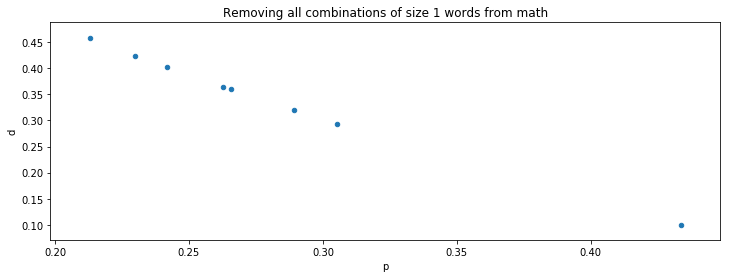

Experiment 3
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['matematica', 'algebra', 'geometria']	['poesia', 'arte', 'danza']	
Experiment 4
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['matematica', 'algebra', 'geometria']	['poesia', 'arte', 'shakespeare']	
Experiment 5
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['matematica', 'algebra', 'geometria']	['filosofia', 'umanesimo', 'arte']	


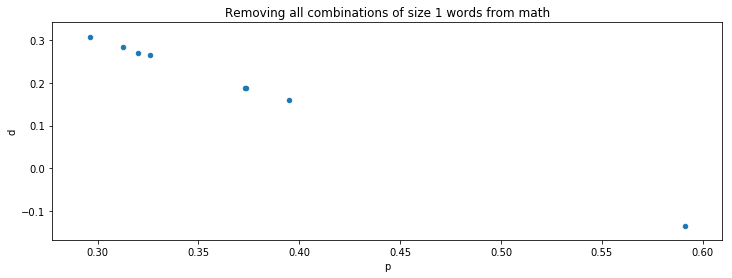

Experiment 6
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['matematica', 'algebra', 'geometria']	['poesia', 'arte', 'danza']	
Experiment 7
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['matematica', 'algebra', 'geometria']	['poesia', 'arte', 'shakespeare']	
Experiment 8
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['matematica', 'algebra', 'geometria']	['filosofia', 'umanesimo', 'arte']	


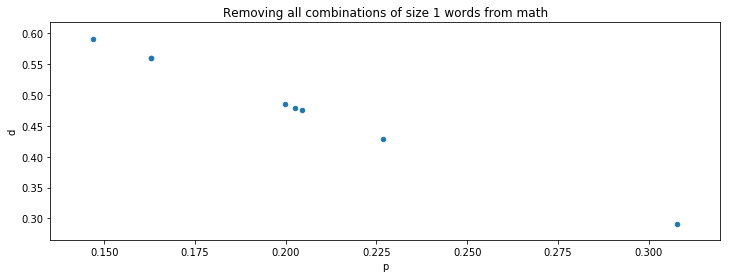

What happens if I run WEAT 7 with the classes male/female, math and art from the other tests?
How much impact does have the class definition on the results?


,count,mean,std,min,25%,50%,75%,max
p,9.0,0.407646,0.159997,0.201777,0.280157,0.373434,0.516084,0.700622


,count,mean,std,min,25%,50%,75%,max
d,9.0,0.141739,0.239533,-0.280386,-0.028704,0.19146,0.335644,0.483975


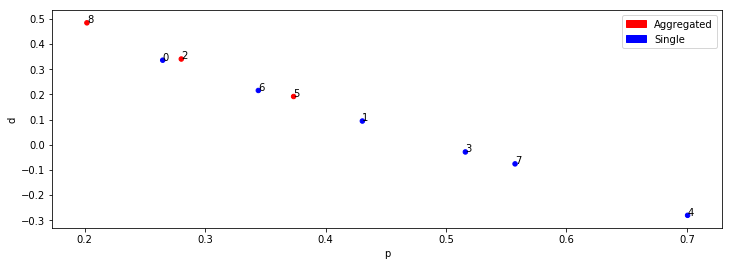

In [12]:
# lavoriamo con male, female, math e art
maths = []
arts = []

experiments = [weat7, weat8, weat8_implicit]

for exp in experiments:
    if 'math' in exp:
        maths.append(exp['math'])
    if 'art' in exp:
        arts.append(exp['art'])
        
results = []
for i, (exp, math, art) in enumerate(product(experiments, maths, arts)):
    print(f'Experiment {i}')
    print(f'{exp["male"]["words"][0:3]}\t{exp["female"]["words"][0:3]}\t{math["words"][0:3]}\t{art["words"][0:3]}\t')
    r = make_experiment(exp['male'], exp['female'], math, art)
    color = 'blue'
    try:
        row = r.loc['mean', ['p', 'd']]
        color = 'red'
    except:
        row = r.loc[0, ['p', 'd']]
    results.append({
        'p': row['p'],
        'd': row['d'],
        'experiment': i,
        'color': color
    })

df_r = pd.DataFrame(results)

print(f'What happens if I run WEAT 7 with the classes male/female, math and art from the other tests?')
print(f'How much impact does have the class definition on the results?')
display(pd.DataFrame(df_r['p'].describe()).T)
display(pd.DataFrame(df_r['d'].describe()).T)

df_r.plot(kind='scatter', x='p', y='d', c='color')
plt.legend(handles=[red_patch, blue_patch])
plt.savefig('weat7_allclasses.eps', format='eps')

for i, r in enumerate(results):
    plt.text(r['p'], r['d'], i)

plt.show()

# WEAT 8 - All classes

Experiment 0
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['scienza', 'tecnologia', 'fisica']	['poesia', 'arte', 'danza']	


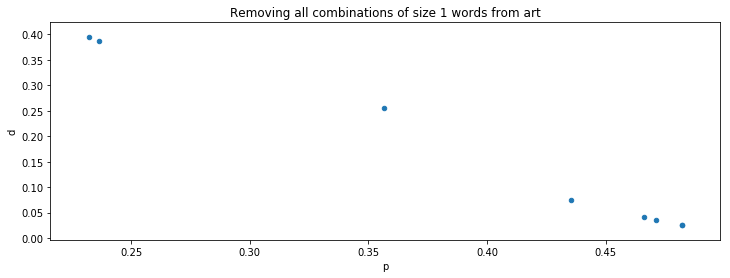

Experiment 1
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['scienza', 'tecnologia', 'fisica']	['poesia', 'arte', 'shakespeare']	


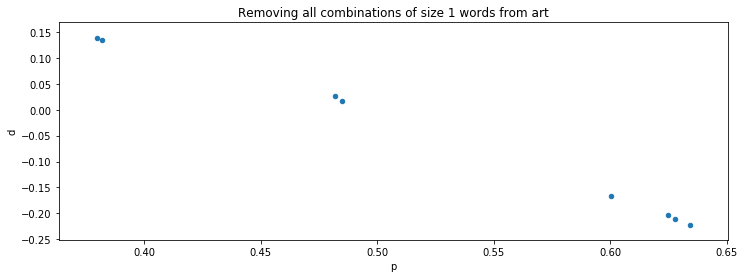

Experiment 2
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['scienza', 'tecnologia', 'fisica']	['filosofia', 'umanesimo', 'arte']	
Experiment 3
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['biologia', 'fisica', 'chimica']	['poesia', 'arte', 'danza']	


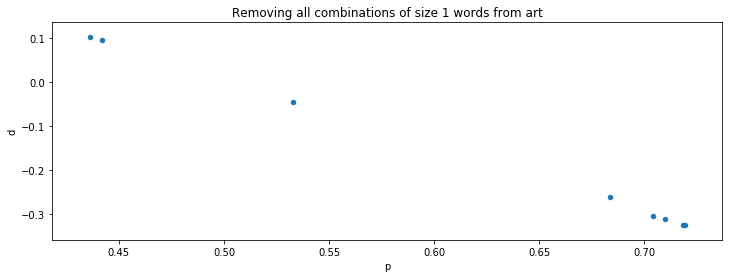

Experiment 4
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['biologia', 'fisica', 'chimica']	['poesia', 'arte', 'shakespeare']	


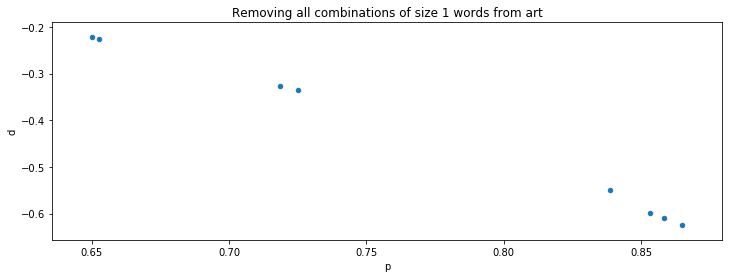

Experiment 5
['maschio', 'uomo', 'ragazzo']	['femmina', 'donna', 'ragazza']	['biologia', 'fisica', 'chimica']	['filosofia', 'umanesimo', 'arte']	
Experiment 6
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['scienza', 'tecnologia', 'fisica']	['poesia', 'arte', 'danza']	


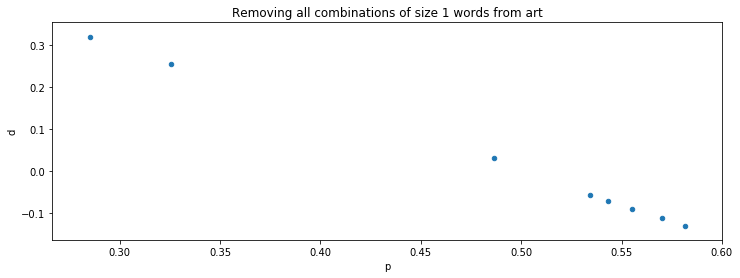

Experiment 7
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['scienza', 'tecnologia', 'fisica']	['poesia', 'arte', 'shakespeare']	


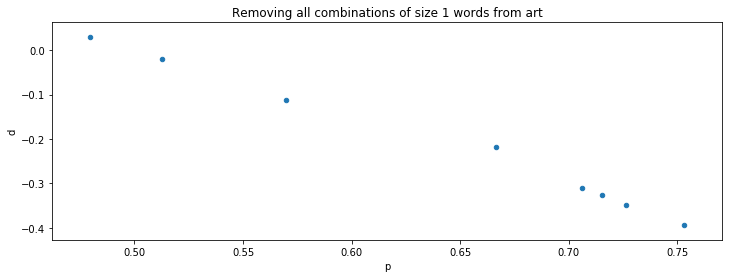

Experiment 8
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['scienza', 'tecnologia', 'fisica']	['filosofia', 'umanesimo', 'arte']	
Experiment 9
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['biologia', 'fisica', 'chimica']	['poesia', 'arte', 'danza']	


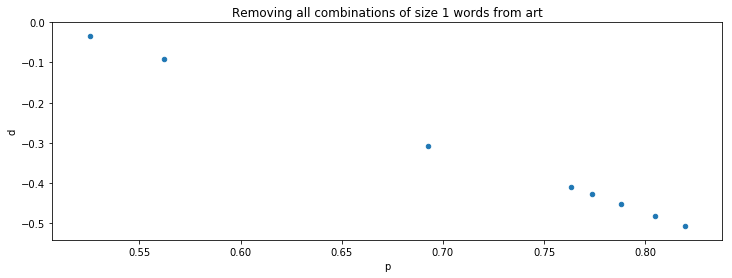

Experiment 10
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['biologia', 'fisica', 'chimica']	['poesia', 'arte', 'shakespeare']	


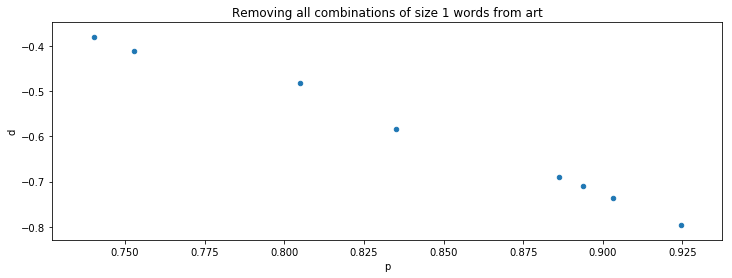

Experiment 11
['fratello', 'padre', 'zio']	['sorella', 'madre', 'zia']	['biologia', 'fisica', 'chimica']	['filosofia', 'umanesimo', 'arte']	
Experiment 12
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['scienza', 'tecnologia', 'fisica']	['poesia', 'arte', 'danza']	


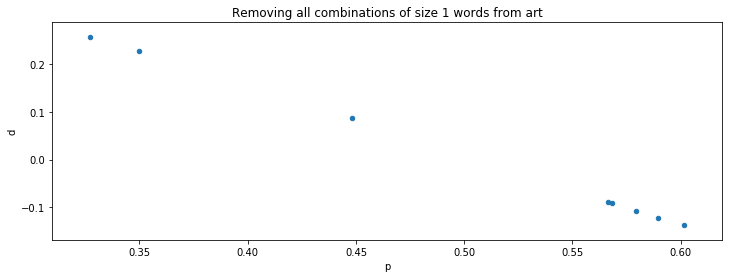

Experiment 13
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['scienza', 'tecnologia', 'fisica']	['poesia', 'arte', 'shakespeare']	


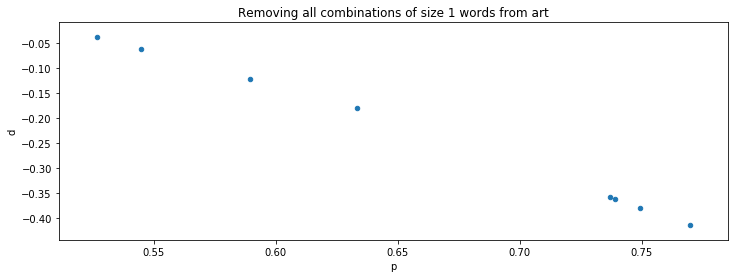

Experiment 14
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['scienza', 'tecnologia', 'fisica']	['filosofia', 'umanesimo', 'arte']	
Experiment 15
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['biologia', 'fisica', 'chimica']	['poesia', 'arte', 'danza']	


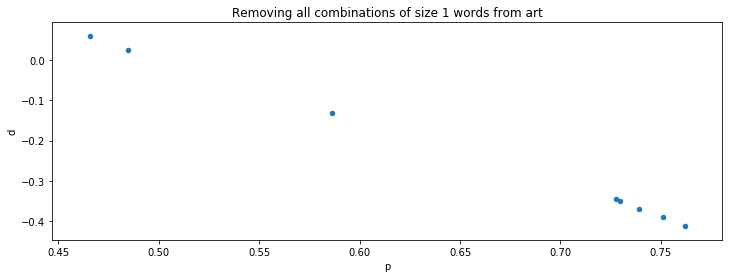

Experiment 16
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['biologia', 'fisica', 'chimica']	['poesia', 'arte', 'shakespeare']	


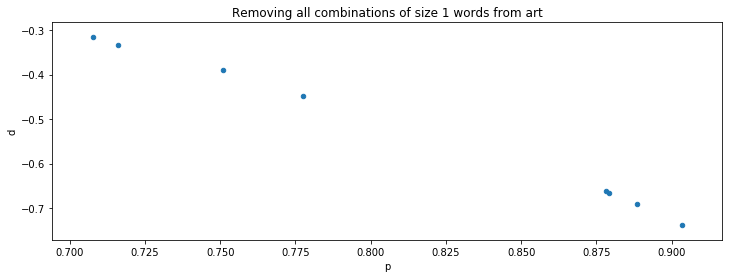

Experiment 17
['uomo', 'padre', 'maschio']	['donna', 'madre', 'femmina']	['biologia', 'fisica', 'chimica']	['filosofia', 'umanesimo', 'arte']	
What happens if I run WEAT 8 / WEAT 8 implicit with the classes male/female, science and art from the other tests?
How much impact does have the class definition on the results?


,count,mean,std,min,25%,50%,75%,max
p,18.0,0.580786,0.153277,0.351107,0.489793,0.614347,0.659801,0.842584


,count,mean,std,min,25%,50%,75%,max
d,18.0,-0.135851,0.243046,-0.598398,-0.239306,-0.168757,0.014561,0.215793


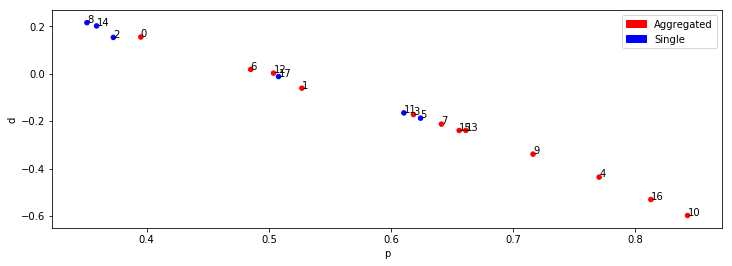

In [13]:
# lavoriamo con male, female, math e art
sciences = []
arts = []

experiments = [weat7, weat8, weat8_implicit]

for exp in experiments:
    if 'science' in exp:
        sciences.append(exp['science'])
    if 'art' in exp:
        arts.append(exp['art'])
        
results = []
for i, (exp, science, art) in enumerate(product(experiments, sciences, arts)):
    print(f'Experiment {i}')
    print(f'{exp["male"]["words"][0:3]}\t{exp["female"]["words"][0:3]}\t{science["words"][0:3]}\t{art["words"][0:3]}\t')
    r = make_experiment(exp['male'], exp['female'], science, art)
    color = 'blue'
    try:
        row = r.loc['mean', ['p', 'd']]
        color = 'red'
    except:
        row = r.loc[0, ['p', 'd']]
    results.append({
        'p': row['p'],
        'd': row['d'],
        'experiment': i,
        'color': color
    })

df_r = pd.DataFrame(results)

print(f'What happens if I run WEAT 8 / WEAT 8 implicit with the classes male/female, science and art from the other tests?')
print(f'How much impact does have the class definition on the results?')
display(pd.DataFrame(df_r['p'].describe()).T)
display(pd.DataFrame(df_r['d'].describe()).T)

df_r.plot(kind='scatter', x='p', y='d', c='color')
plt.legend(handles=[red_patch, blue_patch])
plt.savefig('weat8_allclasses.eps', format='eps')

for i, r in enumerate(results):
    plt.text(r['p'], r['d'], r['experiment'])

plt.show()

# Generic words genre test

In [14]:
genre_test = {
    'male_genre': {
        'name': 'male_genre',
        'words': ['gruzzolo', 'siero', 'teppismo', 'aggiornamento', 'robot']
    },
    'female_genre': {
        'name': 'female_genre',
        'words': ['ossessione', 'salma', 'marcatura', 'libreria', 'rivista']
    }
}

for i, exp in enumerate(experiments):
    print(f'-----\nMale and female classes from experiment {i}')
    genre_test_result = make_experiment(exp['male'], exp['female'], genre_test['male_genre'], genre_test['female_genre'])
    display(genre_test_result)

    evaluate_experiment(genre_test_result, exp['male'], exp['female'], genre_test['male_genre'], genre_test['female_genre'])

    display(experiment_word_frequency(exp['male'], exp['female'], genre_test['male_genre'], genre_test['female_genre']))

-----
Male and female classes from experiment 0


,Target words,Attrib. words,s,d,p,Nt,Na
0,male_genre vs. female_genre,male vs. female,0.778569,1.893757,0.0,5x2,8x2


The result is significant. alpha=0.05 (0.000)
The suggested association is: male_genre-male and female_genre-female(1.894)

male_genre words are 66.439% more frequent than female_genre words
female words are 404.502% more frequent than male words


,class,count
0,male,585374
1,female,2953226
2,male_genre,5361
3,female_genre,3221


-----
Male and female classes from experiment 1


,Target words,Attrib. words,s,d,p,Nt,Na
0,male_genre vs. female_genre,male vs. female,0.663321,1.872055,0.0,5x2,8x2


The result is significant. alpha=0.05 (0.000)
The suggested association is: male_genre-male and female_genre-female(1.872)

male_genre words are 66.439% more frequent than female_genre words
female words are 420.453% more frequent than male words


,class,count
0,male,566687
1,female,2949340
2,male_genre,5361
3,female_genre,3221


-----
Male and female classes from experiment 2


,Target words,Attrib. words,s,d,p,Nt,Na
0,male_genre vs. female_genre,male vs. female,1.057489,1.936245,0.0,5x2,6x2


The result is significant. alpha=0.05 (0.000)
The suggested association is: male_genre-male and female_genre-female(1.936)

male_genre words are 66.439% more frequent than female_genre words
male words are 72.139% more frequent than female words


,class,count
0,male,30040
1,female,17451
2,male_genre,5361
3,female_genre,3221


In [15]:
genre_test = {
    'male_genre': {
        'name': 'male_genre',
        'words': ['governo', 'stato', 'articolo', 'provvedimento', 'emendamento', 'consiglio']
    },
    'female_genre': {
        'name': 'female_genre',
        'words': ['parte', 'legge', 'commissione', 'italia', 'camera', 'materia']
    }
}

for i, exp in enumerate(experiments):
    print(f'-----\nMale and female classes from experiment {i}')
    genre_test_result = make_experiment(exp['male'], exp['female'], genre_test['male_genre'], genre_test['female_genre'])
    display(genre_test_result)

    evaluate_experiment(genre_test_result, exp['male'], exp['female'], genre_test['male_genre'], genre_test['female_genre'])

    display(experiment_word_frequency(exp['male'], exp['female'], genre_test['male_genre'], genre_test['female_genre']))

-----
Male and female classes from experiment 0


,Target words,Attrib. words,s,d,p,Nt,Na
0,male_genre vs. female_genre,male vs. female,0.944452,1.771019,0.0,6x2,8x2


The result is significant. alpha=0.05 (0.000)
The suggested association is: male_genre-male and female_genre-female(1.771)

male_genre words are 5.782% more frequent than female_genre words
female words are 404.502% more frequent than male words


,class,count
0,male,585374
1,female,2953226
2,male_genre,1808449
3,female_genre,1709607


-----
Male and female classes from experiment 1


,Target words,Attrib. words,s,d,p,Nt,Na
0,male_genre vs. female_genre,male vs. female,0.883478,1.775384,0.001082,6x2,8x2


The result is significant. alpha=0.05 (0.001)
The suggested association is: male_genre-male and female_genre-female(1.775)

male_genre words are 5.782% more frequent than female_genre words
female words are 420.453% more frequent than male words


,class,count
0,male,566687
1,female,2949340
2,male_genre,1808449
3,female_genre,1709607


-----
Male and female classes from experiment 2


,Target words,Attrib. words,s,d,p,Nt,Na
0,male_genre vs. female_genre,male vs. female,1.452353,1.791212,0.0,6x2,6x2


The result is significant. alpha=0.05 (0.000)
The suggested association is: male_genre-male and female_genre-female(1.791)

male_genre words are 5.782% more frequent than female_genre words
male words are 72.139% more frequent than female words


,class,count
0,male,30040
1,female,17451
2,male_genre,1808449
3,female_genre,1709607


In [16]:
for w in weat8_implicit['art_no_male']['words']:
    print(w, end=', ')

filosofia, arte, letteratura, italiano, musica, storia, 